In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [3]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

np.random.seed(123)
merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

In [4]:
features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    #"total_precipitation_2023"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income",
    "2m_temperature_2023_avg": "Temp",
    "2m_dewpoint_temperature_2023_avg": "Dew",
    #"total_precipitation_2023": "Precip"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# Random Forest

In [5]:
# Random Forest parameters
rf_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',   
    'bootstrap': True,       # enable bootstrapping
    'random_state': 42,
    'n_jobs': -1            # use all available cores
}

### Random Forest - Within Domain

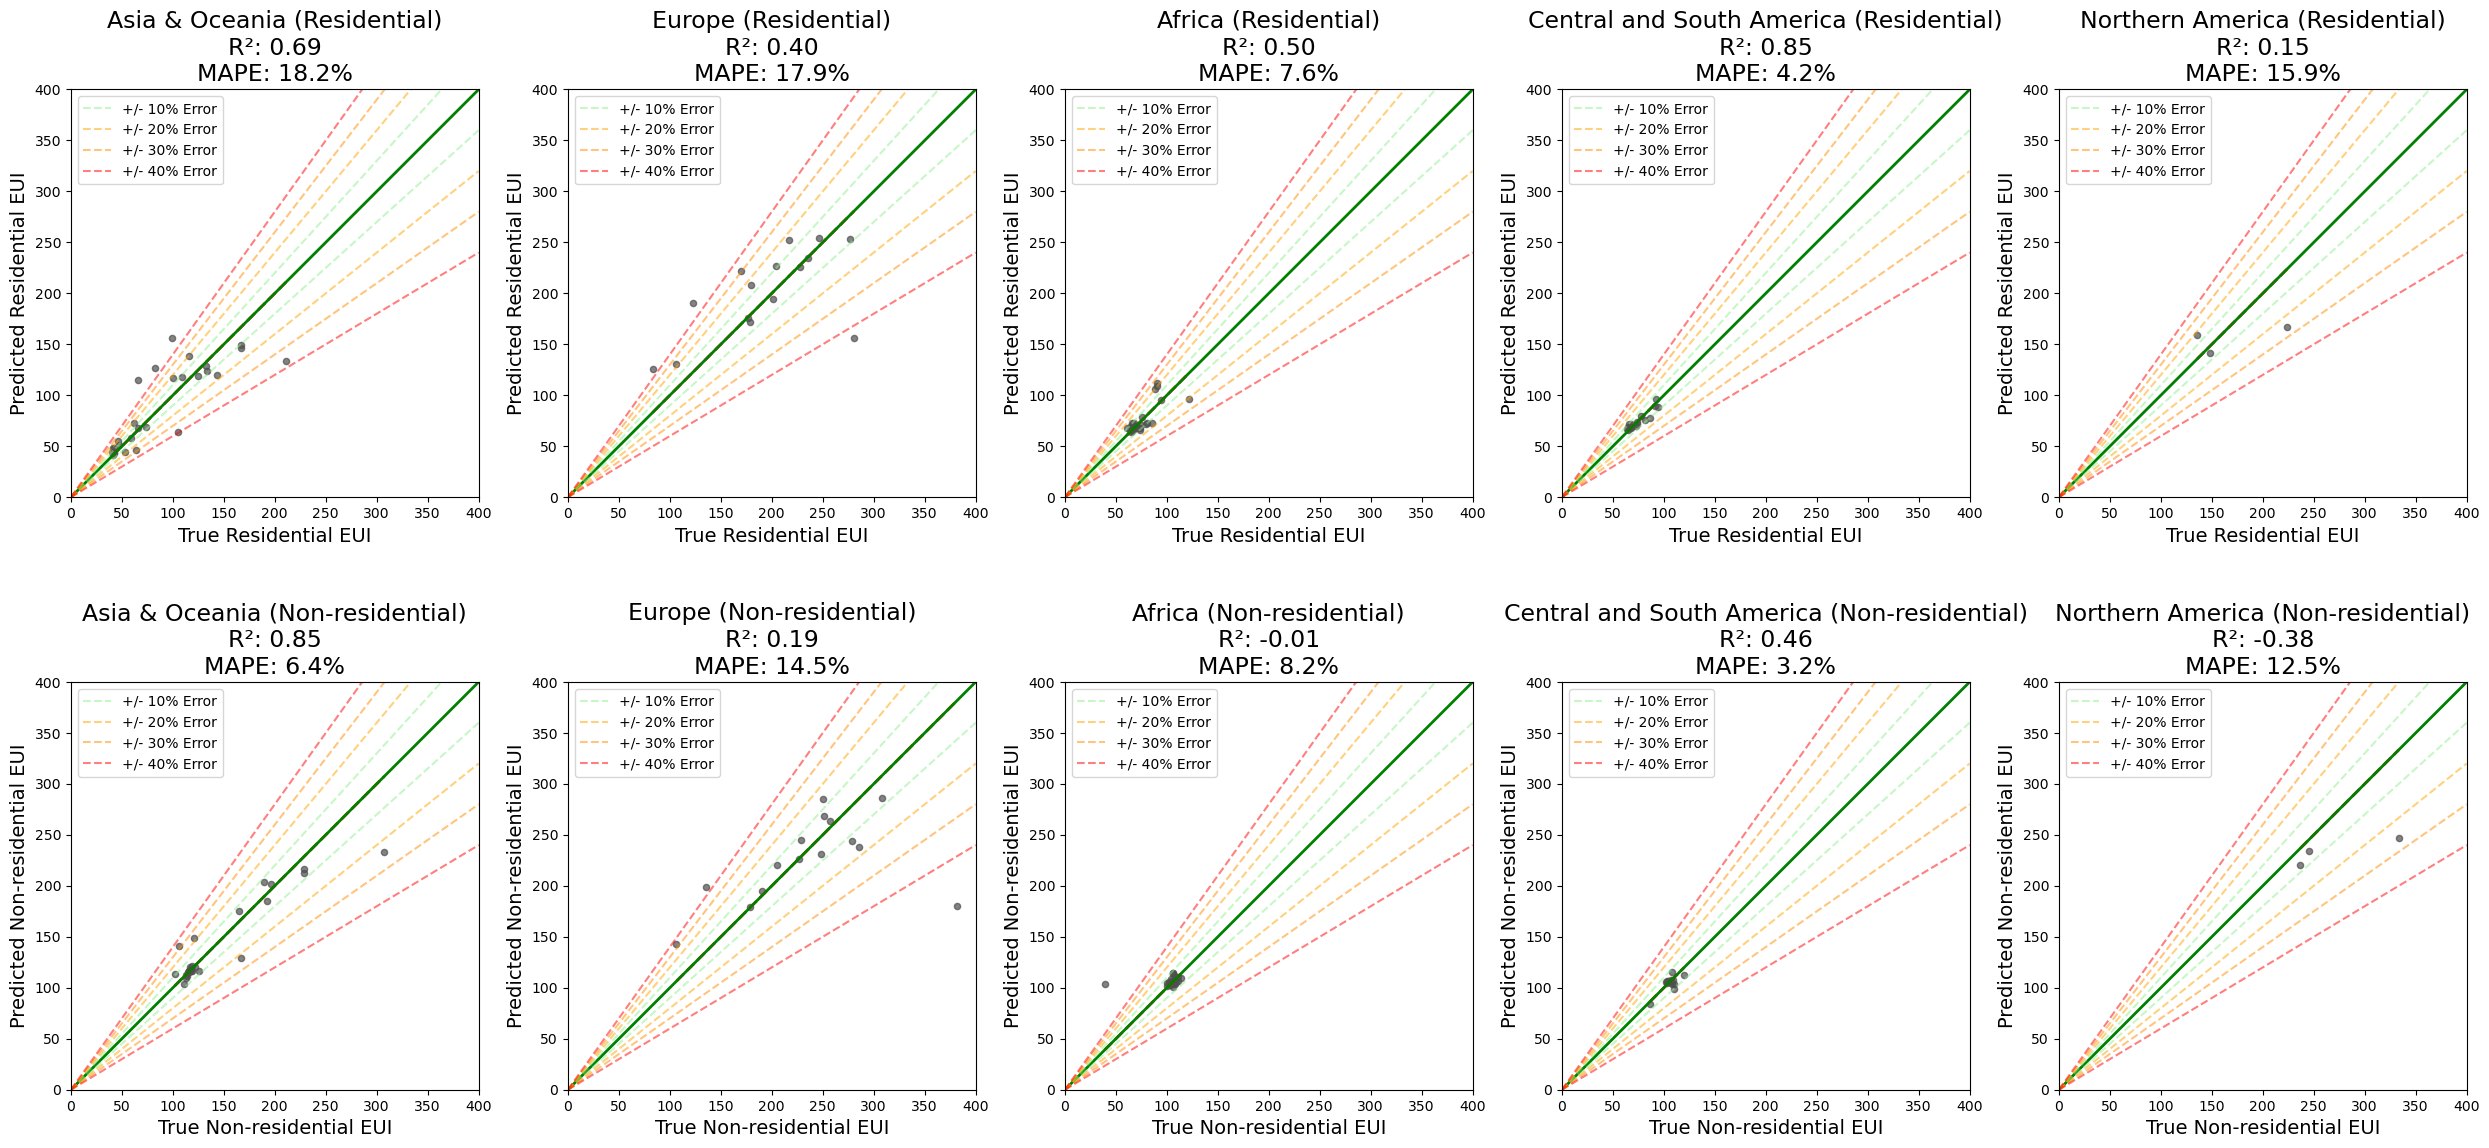

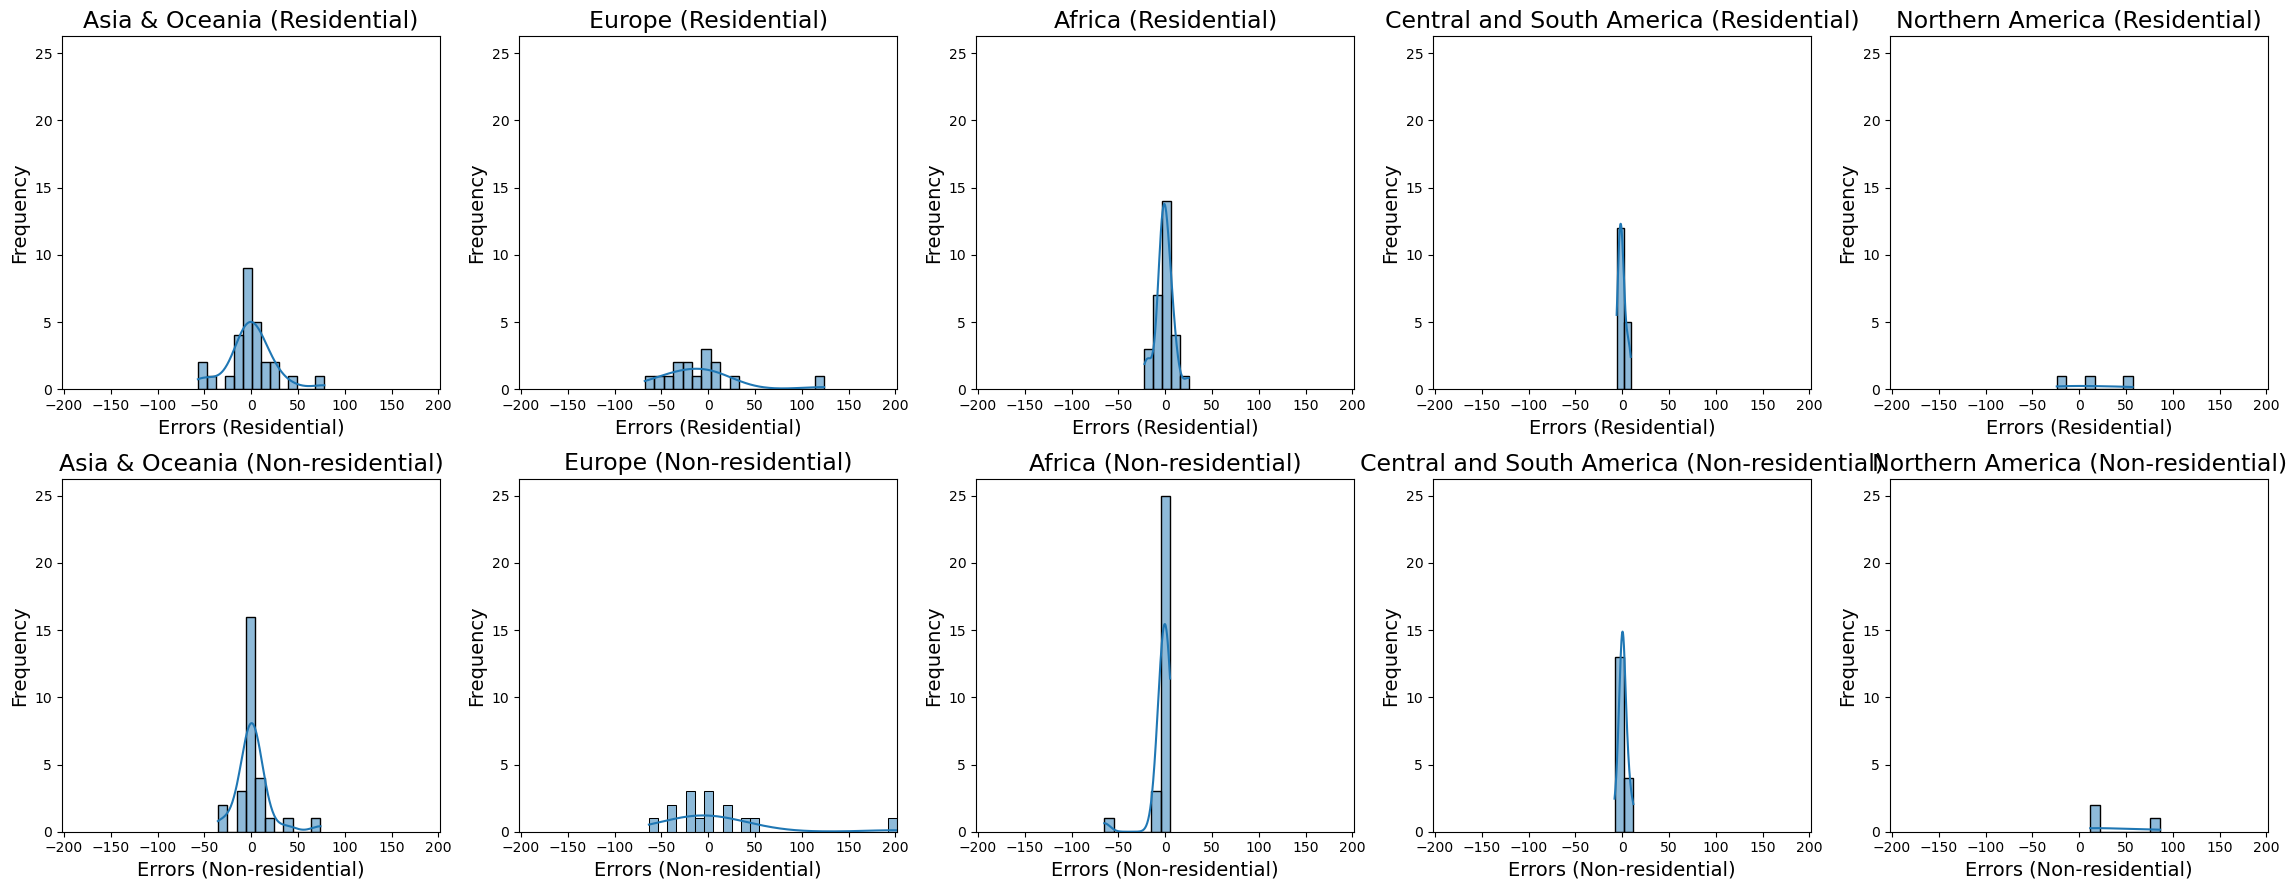

In [6]:
# Within-domain
model_rf_within = RandomForestRegressor(**rf_params)
results_rf_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_rf_within, 
    save_path='../figures/model_plots/rf_within_domain_eui_predictions.png')

create_error_distribution_plots(results_rf_within,
    save_path='../figures/model_plots/rf_within_domain_error_distribution.png')

### Random Forest - Cross Domain

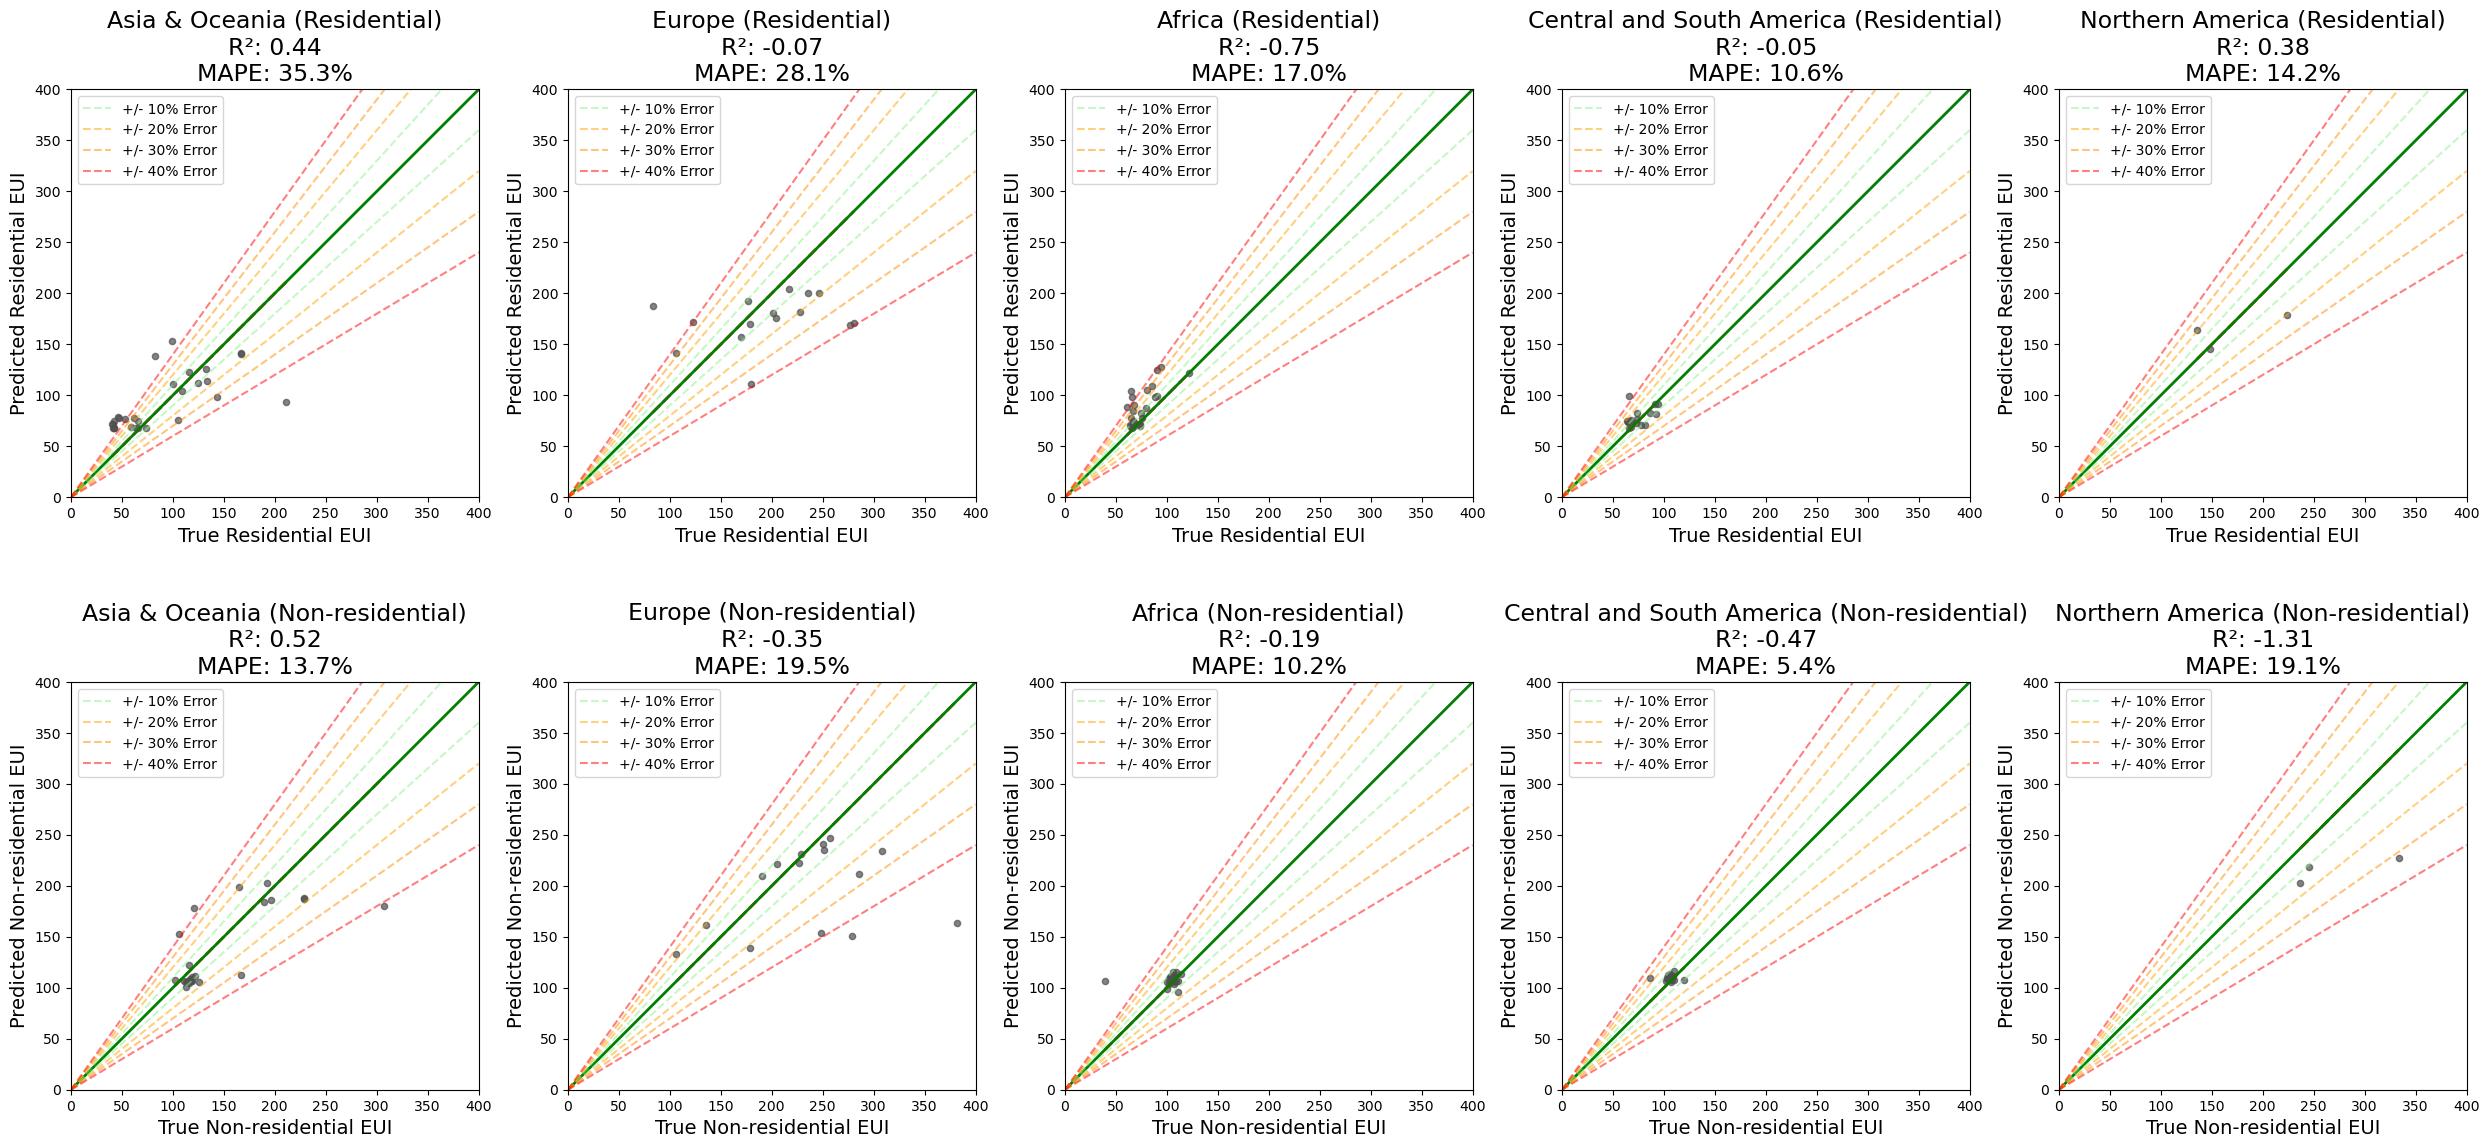

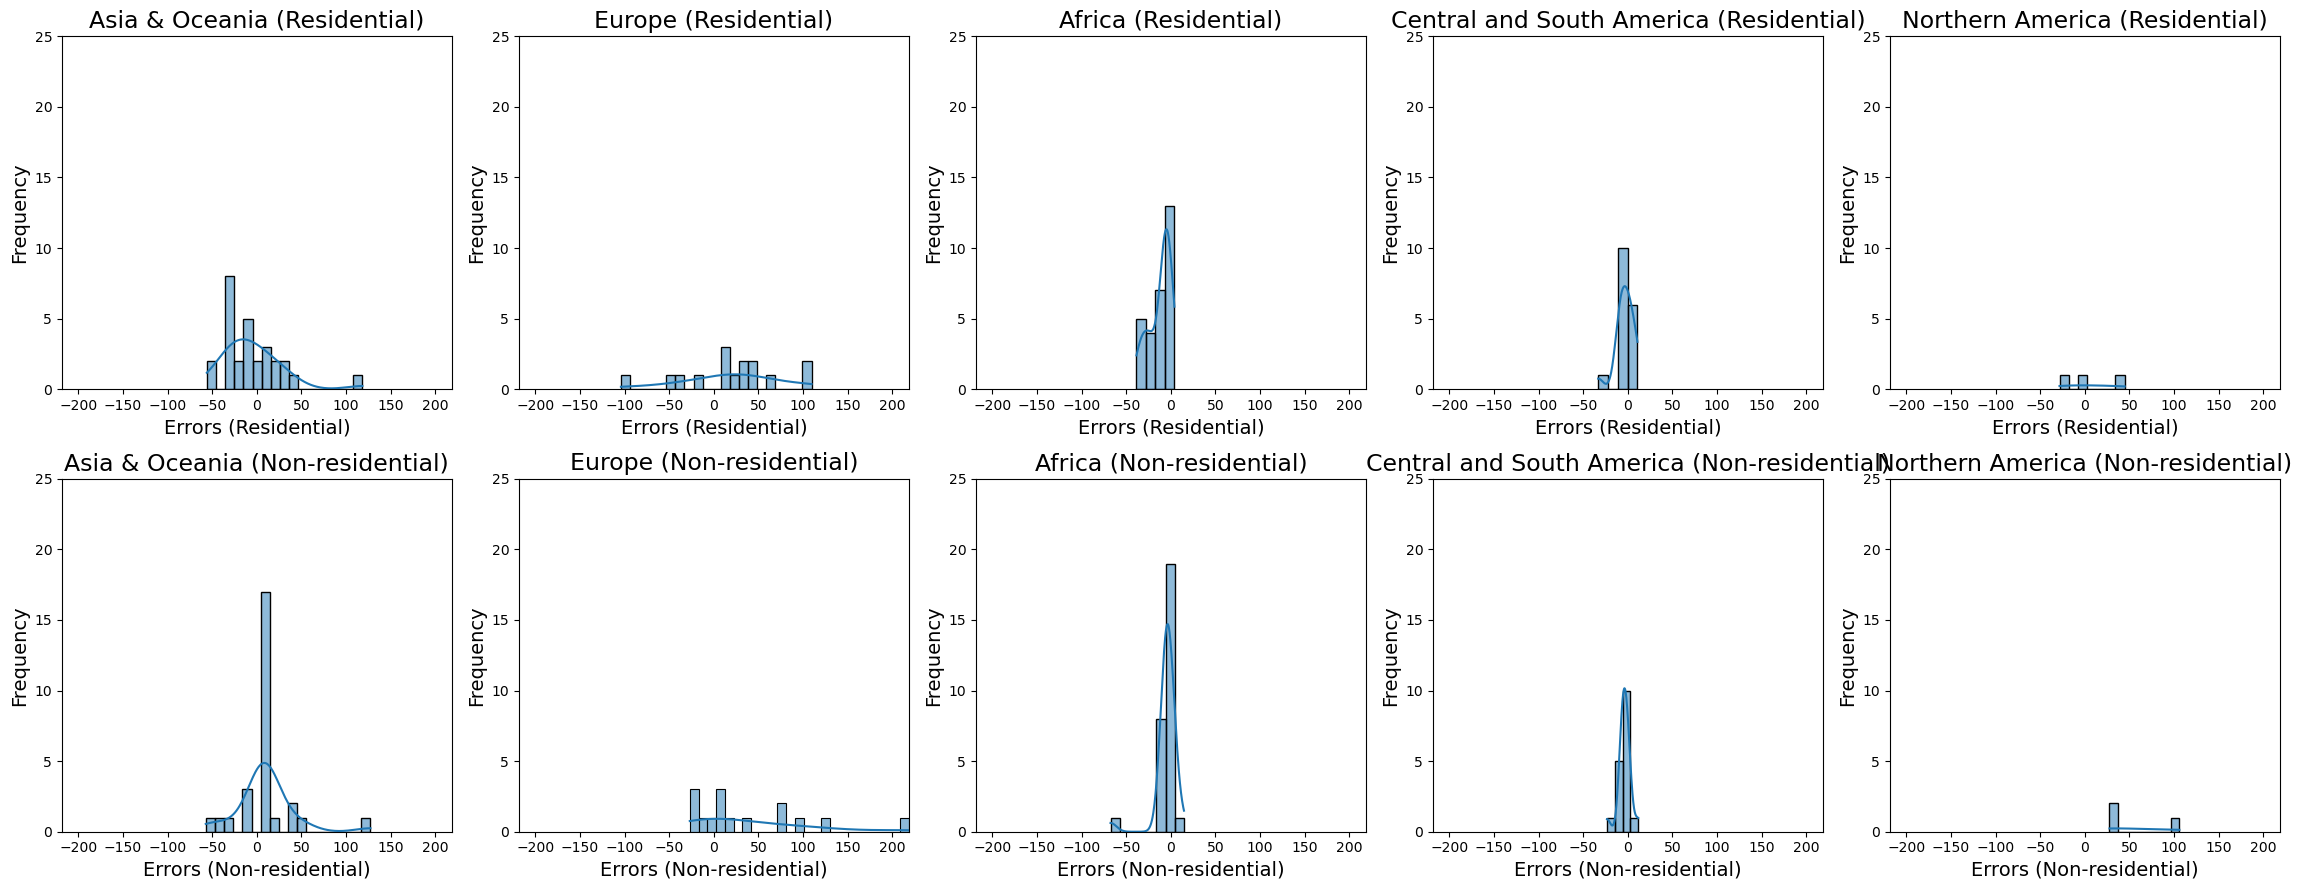

In [7]:
# Cross-domain
model_rf_cross = RandomForestRegressor(**rf_params)
results_rf_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_rf_cross,
    save_path='../figures/model_plots/rf_cross_domain_eui_predictions.png')

create_error_distribution_plots(results_rf_cross,
    save_path='../figures/model_plots/rf_cross_domain_error_distribution.png')

### Random Forest - All Domain

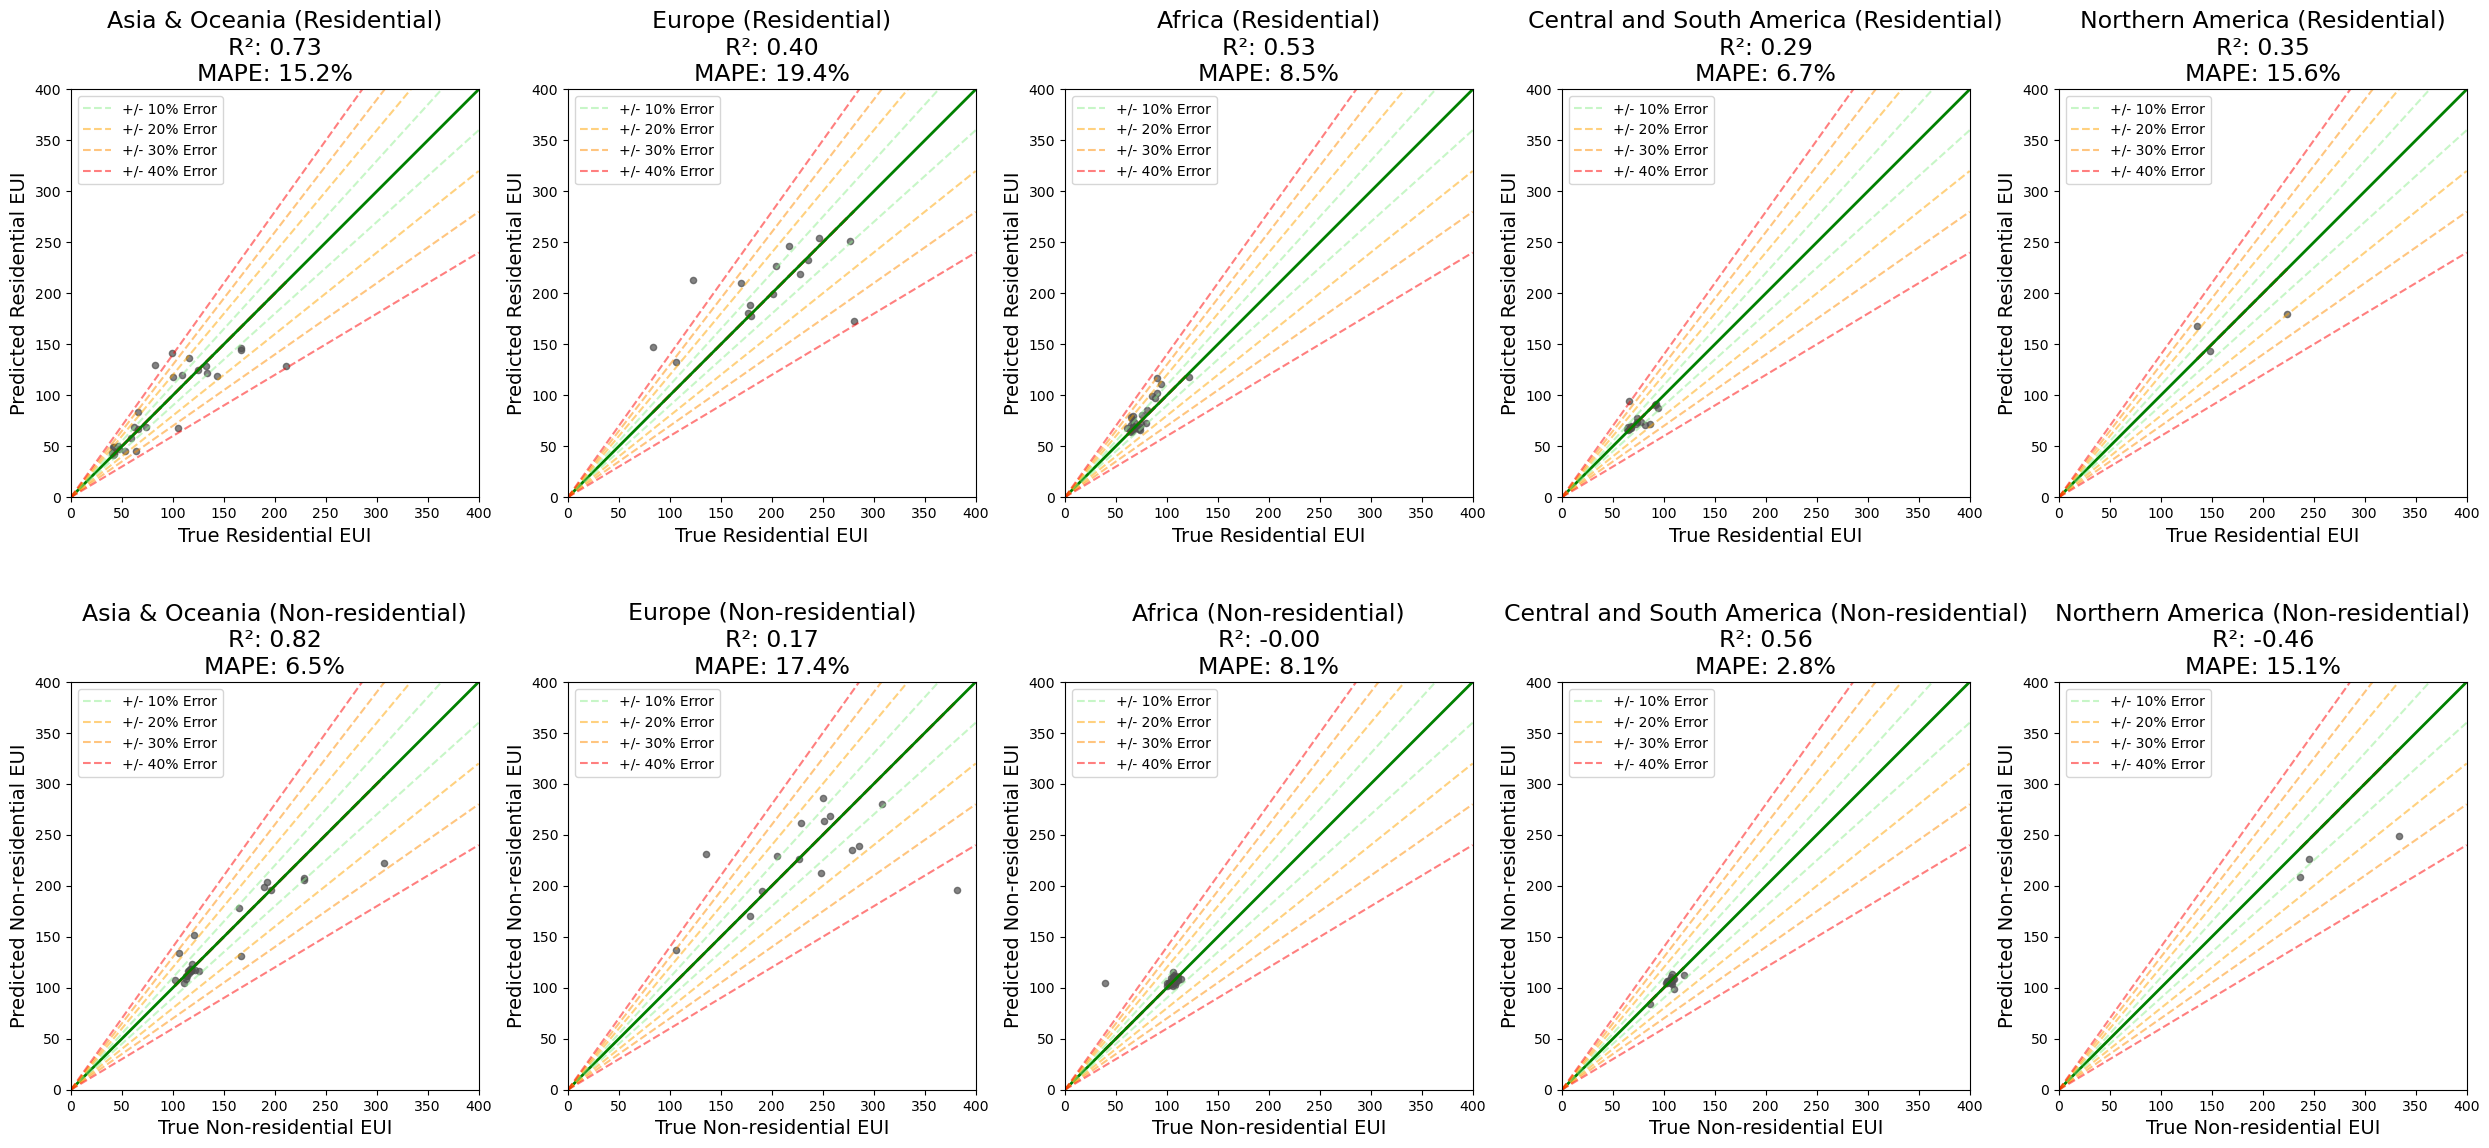

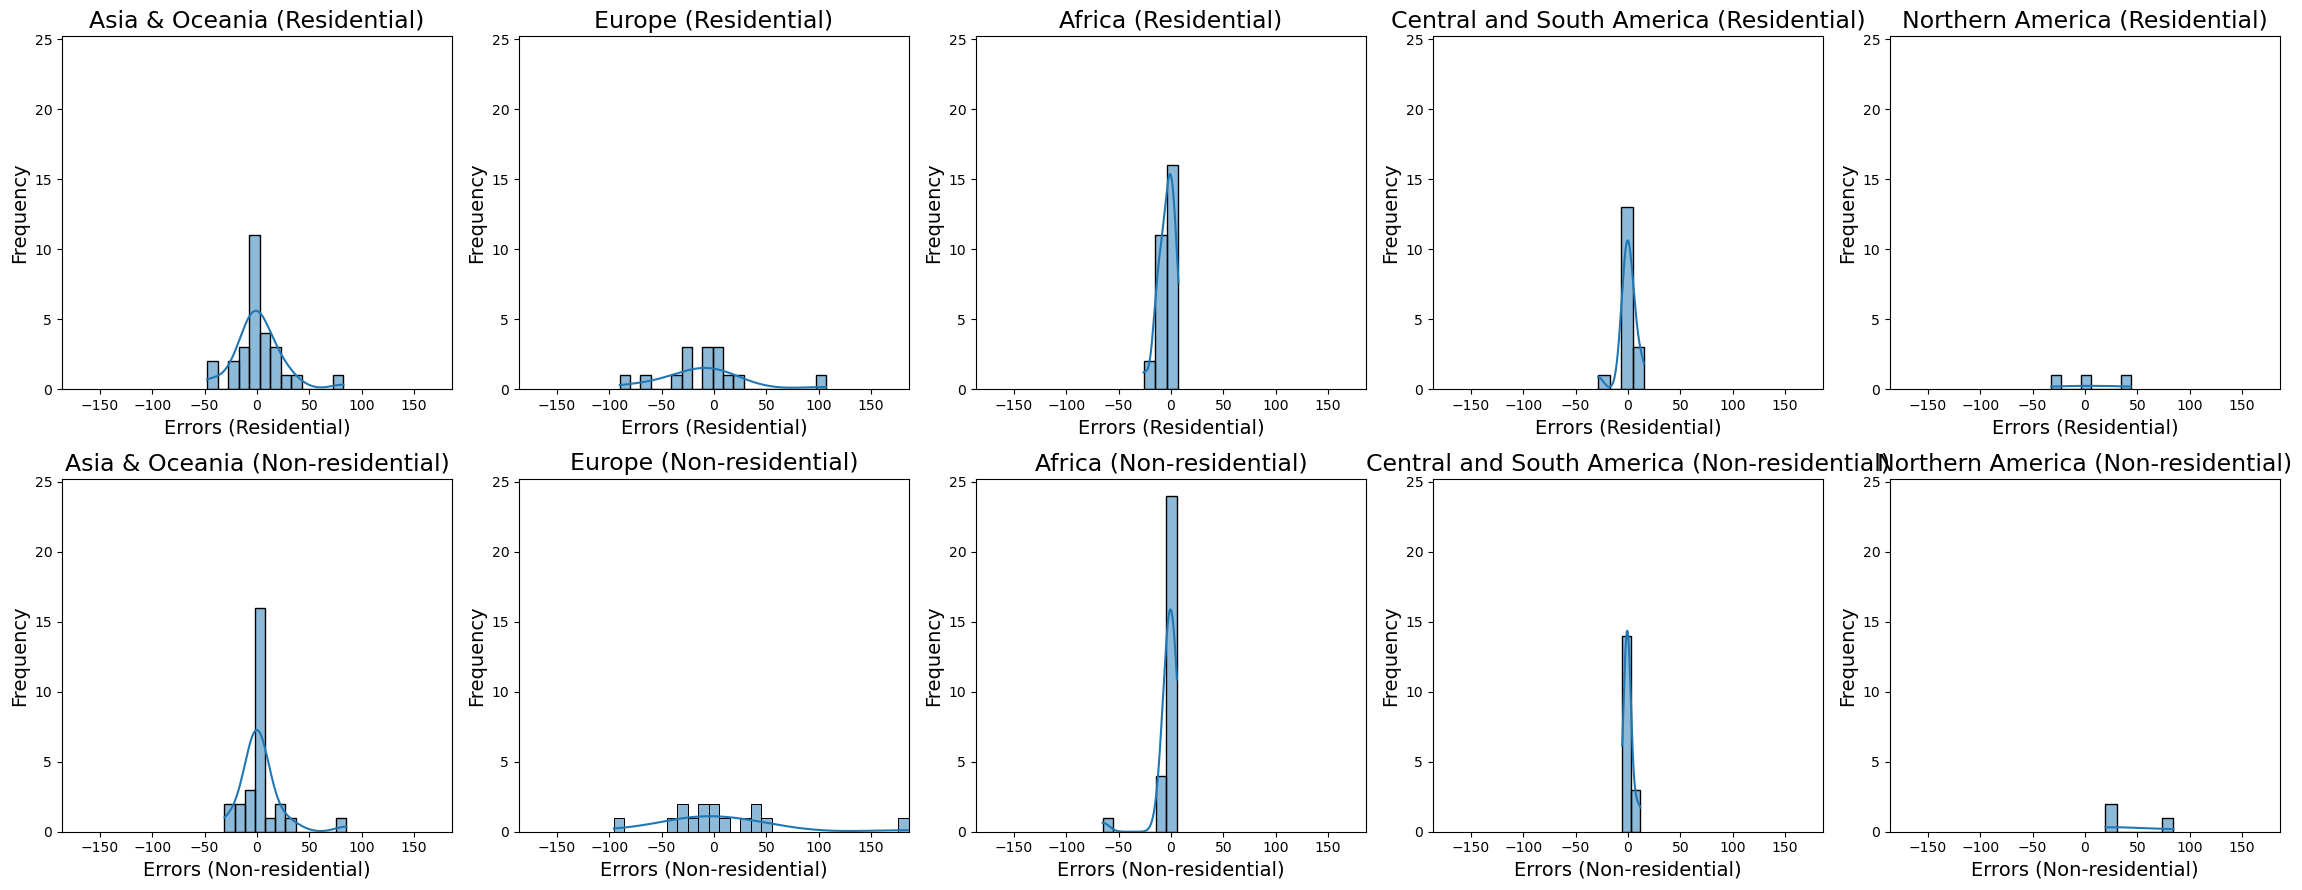

In [8]:
# All-domain
model_rf_all = RandomForestRegressor(**rf_params)
results_rf_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_rf_all,
    save_path='../figures/model_plots/rf_all_domain_eui_predictions.png')

create_error_distribution_plots(results_rf_all,
    save_path='../figures/model_plots/rf_all_domain_error_distribution.png')

In [9]:
RFModel = lambda: RandomForestRegressor(**rf_params)
rf_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=RFModel,  
    feature_abbreviations=feature_abbreviations,
    model_details=", ".join(f"{k}={v}" for k, v in rf_params.items())
)
rf_detailed_results['Model'] = 'RandomForestRegressor'

rf_average_results = calculate_average_metrics(rf_detailed_results).reset_index()
rf_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,RandomForestRegressor,"n_estimators=100, max_depth=None, min_samples_...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,8.96,0.222,1334.423,29.337,18.288,8.78
1,Non-residential EUI (kWh/m2/year),cross_domain,RandomForestRegressor,"n_estimators=100, max_depth=None, min_samples_...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,13.58,-0.358,2324.499,39.532,28.055,13.78
2,Non-residential EUI (kWh/m2/year),all_domain,RandomForestRegressor,"n_estimators=100, max_depth=None, min_samples_...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,9.98,0.218,1398.354,30.044,20.528,9.66
3,Residential EUI (kWh/m2/year),within_domain,RandomForestRegressor,"n_estimators=100, max_depth=None, min_samples_...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,12.76,0.517,788.542,23.637,17.089,12.90
4,Residential EUI (kWh/m2/year),cross_domain,RandomForestRegressor,"n_estimators=100, max_depth=None, min_samples_...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,21.04,-0.010,1173.201,30.079,23.554,19.00
5,Residential EUI (kWh/m2/year),all_domain,RandomForestRegressor,"n_estimators=100, max_depth=None, min_samples_...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,13.08,0.461,719.675,23.227,16.675,12.80


In [10]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
rf_detailed_results.to_csv(f'../results/{timestamp}_rf_detailed_results.csv')
rf_average_results.to_csv(f'../results/{timestamp}_rf_average_results.csv')

# 